<a href="https://colab.research.google.com/github/dlevine01/forecast-affordable-housing/blob/main/notebooks/Logistic_Regression_Model_testing_varying_sample_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test the effect of sample size on model performance (recall)

The number of true positives (properties that were actually developed or perserved under the Housing New York plan) is tiny compared to the total number of properties across New York City. This inbalance is a challenge for prediction models.

One approach for balancing the data is to take a sample of the overrepresented class (here, true negatives, or properties actually not part of Housing New York).

Here I test and show the effect of sample size on model recall

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from zipfile import ZipFile
from matplotlib.colors import Normalize
import seaborn as sns

In [ ]:
pip install geopandas 

     |████████████████████████████████| 1.0 MB 19.6 MB/s 
     |████████████████████████████████| 6.3 MB 49.3 MB/s 
     |████████████████████████████████| 16.7 MB 47.4 MB/s 


In [ ]:
import geopandas as gpd

In [ ]:
sns.set_theme(style='white')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/ADS/ADS Project - Affordable Housing/processed data/'

In [ ]:
# load/clean data

In [ ]:
# 2013 data for model
filter_df = pd.read_csv(f'{path}filtered_df.csv') # to read in from Google Drive to Colab
filter_df = filter_df.drop(columns = ['total population',
                                      'denominator: total population for Race',
                                      'denominator: total population for Hispanic or Latino',
                                      'Census Tract FIPS 2010', 
                                      'Unnamed: 0', 
                                      'CT2010'])
filter_df['IRRLOTCODE'] = (filter_df['IRRLOTCODE'] == 'Y').astype(int)


usecols = ['LOTAREA', 'BLDGAREA', 'COMAREA', 'RESAREA', 'OFFICEAREA', 'RETAILAREA',
       'STRGEAREA', 'FACTRYAREA', 'NUMFLOORS', 'UNITSRES', 'BLDGFRONT',
       'BLDGDEPTH', 'IRRLOTCODE', 'ASSESSLAND', 'ASSESSTOT', 'YEARBUILT',
       'BUILTFAR', 'RESIDFAR', 'median gross rent', 'median income',
       'total: White', 'total: Black', 'total: Asian',
       'total: Hispanic or Latino (any race)',
       'total: income below poverty level',
       'total paying more than 50 percent of income on rent']

#### 2021 data for forecast

In [ ]:
filter_df_2021 = pd.read_csv(f'{path}data_2021_cleaned.csv', index_col=0)
filter_df_2021 = filter_df_2021.dropna()
xf_df_2021 = filter_df_2021.drop('BBL', axis=1)

#### parcel locations to map, borough bounds, and tract bounds to map

In [ ]:
!curl 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_21v4_csv.zip' --output '2021.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 89.3M  100 89.3M    0     0  60.7M      0  0:00:01  0:00:01 --:--:-- 60.7M


In [ ]:
with ZipFile('2021.zip') as container:
  csv_file = [file for file in container.namelist() if file[-4:] == '.csv'][0]
  with container.open(csv_file) as file:
      pluto_2021 = pd.read_csv(file, usecols=['bbl','latitude', 'longitude', 'zipcode'])

In [ ]:
pluto_2021_geo = gpd.GeoDataFrame(
    data=pluto_2021,
    geometry=gpd.points_from_xy(
        pluto_2021['longitude'],
        pluto_2021['latitude']),
        crs = 'EPSG:2263')

In [ ]:
pluto_2021

,zipcode,bbl,latitude,longitude,geometry
0,10003.0,1.005638e+09,40.733326,-73.991972,POINT (-73.992 40.733)
1,11223.0,3.071330e+09,40.597676,-73.964833,POINT (-73.965 40.598)
2,11223.0,3.071530e+09,40.593135,-73.969560,POINT (-73.970 40.593)
3,11432.0,4.068650e+09,40.715699,-73.803864,POINT (-73.804 40.716)
4,11426.0,4.086580e+09,40.725978,-73.723547,POINT (-73.724 40.726)
...,...,...,...,...,...
859027,10312.0,5.065550e+09,40.529020,-74.184998,POINT (-74.185 40.529)
859028,10309.0,5.068550e+09,40.529957,-74.198739,POINT (-74.199 40.530)
859029,10312.0,5.063160e+09,40.542891,-74.192064,POINT (-74.192 40.543)
859030,NaN,1.020450e+09,NaN,NaN,POINT EMPTY


In [ ]:
boroughs = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON')

In [ ]:
nyc_tracts = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2010_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')

In [ ]:
borough_crosswalk = {'1':'061',
                     '3':'047',
                     '4':'081',
                     '5':'085',
                     '2':'005'}

In [ ]:
nyc_tracts['GEOID'] = ('36' + nyc_tracts['BoroCode'].map(borough_crosswalk) + nyc_tracts['CT2010']).astype(int)

In [ ]:
tract_lookup = pd.read_csv(f'{path}pluto_2021.csv', usecols=['BBL', 'Census Tract FIPS 2010'])

In [ ]:
norm = Normalize(0,1)

# model with varying sample sizes
output maps
record accuracy scores


  ___ at sample size = 3655  ___  
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       738
           1       0.79      0.91      0.85       724

    accuracy                           0.84      1462
   macro avg       0.84      0.84      0.84      1462
weighted avg       0.84      0.84      0.84      1462

score = 0.8296853625170999


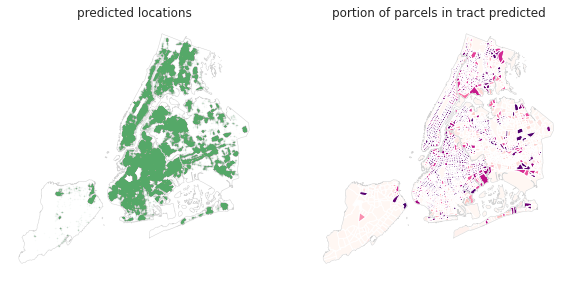


  ___ at sample size = 6522  ___  
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1262
           1       0.76      0.83      0.80       774

    accuracy                           0.84      2036
   macro avg       0.83      0.84      0.83      2036
weighted avg       0.84      0.84      0.84      2036

score = 0.8447937131630648


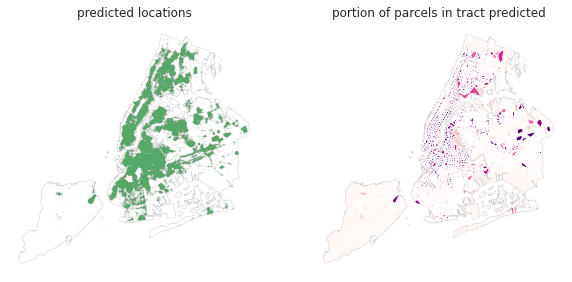


  ___ at sample size = 11640  ___  
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2330
           1       0.68      0.74      0.71       729

    accuracy                           0.86      3059
   macro avg       0.80      0.82      0.81      3059
weighted avg       0.86      0.86      0.86      3059

score = 0.8555083360575352


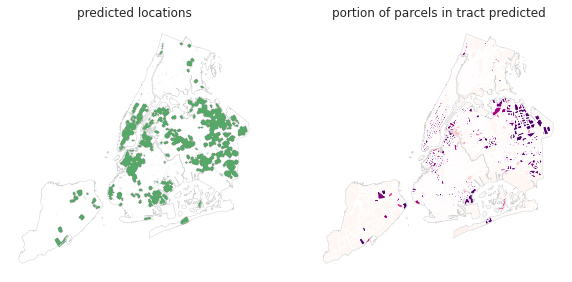


  ___ at sample size = 20773  ___  
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4142
           1       0.63      0.58      0.60       744

    accuracy                           0.88      4886
   macro avg       0.78      0.76      0.77      4886
weighted avg       0.88      0.88      0.88      4886

score = 0.8798608268522309


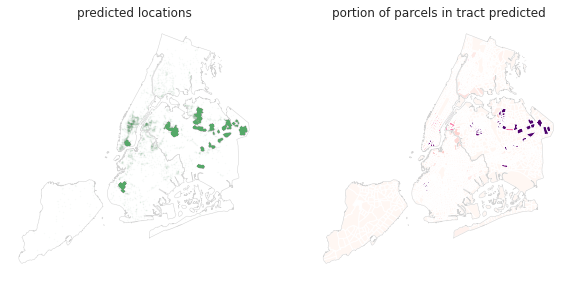


  ___ at sample size = 37071  ___  
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7404
           1       0.56      0.39      0.46       742

    accuracy                           0.92      8146
   macro avg       0.75      0.68      0.70      8146
weighted avg       0.91      0.92      0.91      8146

score = 0.9150503314510189


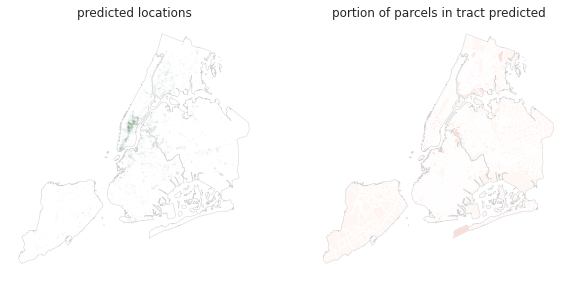


  ___ at sample size = 66158  ___  
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     13241
           1       0.48      0.25      0.33       722

    accuracy                           0.95     13963
   macro avg       0.72      0.62      0.65     13963
weighted avg       0.94      0.95      0.94     13963

score = 0.9495094177469026


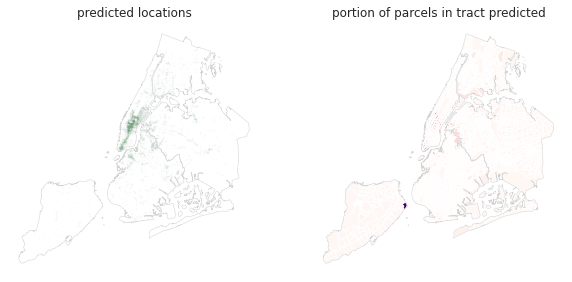


  ___ at sample size = 118065  ___  
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     23658
           1       0.44      0.17      0.25       686

    accuracy                           0.97     24344
   macro avg       0.71      0.58      0.62     24344
weighted avg       0.96      0.97      0.96     24344

score = 0.9721902727571475


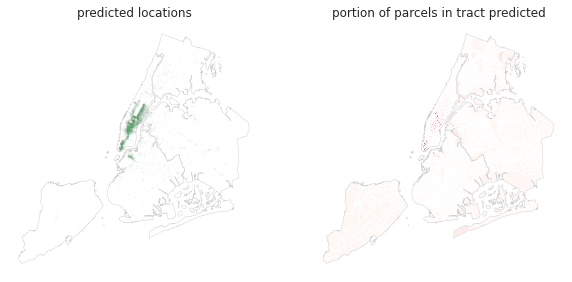


  ___ at sample size = 210698  ___  
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     42114
           1       0.47      0.09      0.15       757

    accuracy                           0.98     42871
   macro avg       0.73      0.54      0.57     42871
weighted avg       0.97      0.98      0.98     42871

score = 0.982902194956964


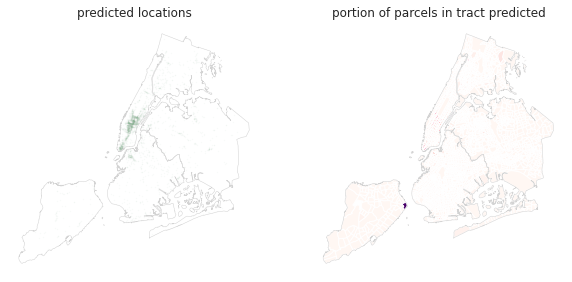


  ___ at sample size = 376010  ___  
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75219
           1       0.50      0.07      0.12       714

    accuracy                           0.99     75933
   macro avg       0.74      0.54      0.56     75933
weighted avg       0.99      0.99      0.99     75933

score = 0.9907681772088551


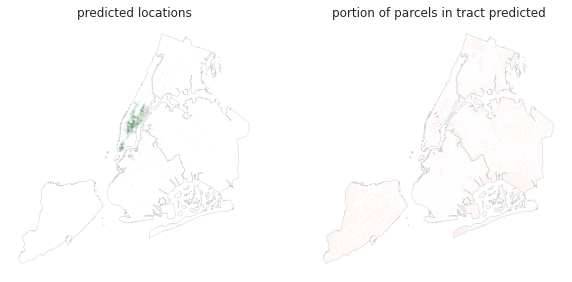


  ___ at sample size = 671026  ___  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    134247
           1       0.45      0.07      0.12       690

    accuracy                           0.99    134937
   macro avg       0.72      0.54      0.56    134937
weighted avg       0.99      0.99      0.99    134937

score = 0.9949383786507777


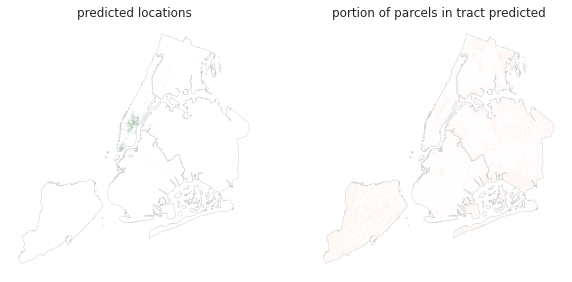

,sample size,score,precision,recall,num parcels predicted
0,3655,0.829685,0.794189,0.906077,373728.0
1,6522,0.844794,0.761229,0.832041,240340.0
2,11640,0.855508,0.684076,0.736626,192338.0
3,20773,0.879861,0.629738,0.580645,32933.0
4,37071,0.915050,0.556420,0.385445,3990.0
5,66158,0.949509,0.478723,0.249307,5510.0
6,118065,0.972190,0.441176,0.174927,6600.0
7,210698,0.982902,0.472603,0.091149,2516.0
8,376010,0.990768,0.495146,0.071429,3522.0
9,671026,0.994938,0.445455,0.071014,1242.0


In [ ]:
n_true_positives = (filter_df['is_HNY']==1).sum()
n_true_negatives = (filter_df['is_HNY']==0).sum()

# 10 sample sizes between samples = true positives and full data
sample_sizes = np.floor(np.geomspace(n_true_positives,n_true_negatives, 10))

results_list = []

for sample_size in sample_sizes:
    
    sample_size = int(sample_size)

    # sample
    filter_df0 = filter_df[(filter_df['is_HNY']==0.0)] # creating a dataframe with only overrepresented class rows
    filter_df0_sample = filter_df0.sample(n=sample_size) # sample from overrepresented class 
    filter_df1 = filter_df[(filter_df['is_HNY']==1.0)]
    sampled_df = pd.concat([filter_df0_sample, filter_df1]) # concatenating data from both classes
    sampled_df1 = sampled_df.sample(frac=1, random_state = 1) # shuffling the data

    # Define features and target variable
    xf_df = sampled_df1[usecols]
    yf_df = sampled_df1['is_HNY'].values
    
    # standardize, pc-transform
    scaler = preprocessing.StandardScaler().fit(xf_df)
    xf_df_scaled = scaler.transform(xf_df)
    pca1 = PCA(7)
    xf_df_principal1 = pca1.fit_transform(xf_df_scaled)
    Xtr_pca, Xts_pca, ytr_pca, yts_pca = train_test_split(xf_df_principal1, yf_df, test_size=0.2, random_state=13)

    # fit model
    logist_pca = LogisticRegression(C=1e5,class_weight='unbalanced')
    logist_pca.fit(Xtr_pca, ytr_pca)
    yhat_pca = (logist_pca.predict_proba(Xts_pca)[:,1] >= 0.352).astype(float)
    yts_pca = np.array(yts_pca)

    # check model performance. store results
    cm = metrics.confusion_matrix(yts_pca, yhat_pca)
    score = logist_pca.score(Xts_pca, yts_pca)
    recall = metrics.recall_score(yts_pca, yhat_pca)
    precision = metrics.precision_score(yts_pca, yhat_pca)

    print(f'\n  ___ at sample size = {sample_size}  ___  ')
    print(classification_report(yts_pca, yhat_pca, target_names=['0','1']))
    print(f'score = {score}')

    
    # feed in new data to model that has been fit
    xf_df_2021_scaled = scaler.transform(xf_df_2021)
    xf_df_2021_principal1 = pca1.fit_transform(xf_df_2021_scaled)

    # predict future condistion by tract
    yhat_pca_2021 = (logist_pca.predict_proba(xf_df_2021_principal1)[:,1] >= 0.352).astype(float)
    parcels_predicted = filter_df_2021[yhat_pca_2021 == 1]['BBL']

    num_parcels_predicted = yhat_pca_2021.sum()

    # map predicted parcels
    pluto_predicted = pluto_2021_geo.loc[pluto_2021_geo['bbl'].isin(parcels_predicted)]


    # compute percent predicted by tract
    tract_lookup_ = tract_lookup.copy()
    tract_lookup_['predicted'] = tract_lookup_['BBL'].isin(pluto_predicted['bbl'])
    tract_predict_pct_ = (
        tract_lookup_.groupby('Census Tract FIPS 2010')['predicted'].sum() 
        / tract_lookup_.groupby('Census Tract FIPS 2010')['predicted'].count())

    nyc_tracts_ = nyc_tracts.merge(
        tract_predict_pct_, 
        left_on='GEOID', 
        right_on='Census Tract FIPS 2010')
    
    # map tracts by percent predicted + locations of predicted
    fig, (parcel_map, tract_map) = plt.subplots(1,2,figsize=(10,20))
    nyc_tracts_.plot(
        ax=tract_map,
        column='predicted',
        cmap='RdPu',
        norm=norm)
    pluto_predicted.plot(
        ax=parcel_map, 
        marker='.', 
        markersize=0.1, 
        color='g', 
        alpha=0.1)
    boroughs.plot(
        ax=tract_map,
        facecolor='none',
        edgecolor='lightgrey',
        linewidth=0.5)
    boroughs.plot(
        ax=parcel_map,
        facecolor='none',
        edgecolor='lightgrey',
        linewidth=0.5)
    tract_map.axis('off')
    parcel_map.axis('off')
    plt.title(f'Predictions with sample size = {sample_size}')
    tract_map.set_title('portion of parcels in tract predicted')
    parcel_map.set_title('predicted locations')
    plt.show()

    # store results
    results_list.append({
    'sample size':sample_size,
    'score' : score,
    'precision': precision,
    'recall' : recall,
    'cm':cm,
    'num parcels predicted':num_parcels_predicted,
    'parcels predicted':parcels_predicted.values
    })

# concat results, show table and plot
results = pd.DataFrame.from_records(results_list, exclude=['cm', 'parcels predicted'])
results

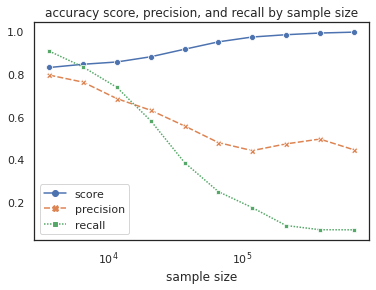

In [ ]:
sns.lineplot(data=results.set_index('sample size')[['score','precision', 'recall']], markers=True);
plt.xscale('log')
plt.title('accuracy score, precision, and recall by sample size');

In [ ]:
baseline = n_true_positives / filter_df.shape[0]
baseline

0.005417375026123457

Text(0, 0.5, 'recall score')

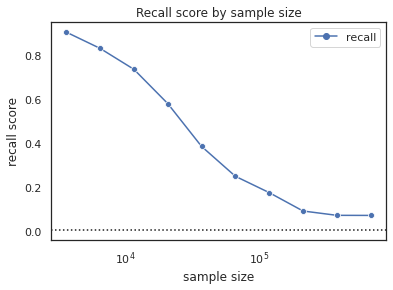

In [ ]:
sns.lineplot(data=results.set_index('sample size')[['recall']], markers=True);
plt.xscale('log')
plt.gca().axhline(baseline, c='k', ls=':')
plt.title('Recall score by sample size');
plt.ylabel('recall score')

In [ ]:
results['true negative sample : true positive ratio'] = results['sample size'] / n_true_positives

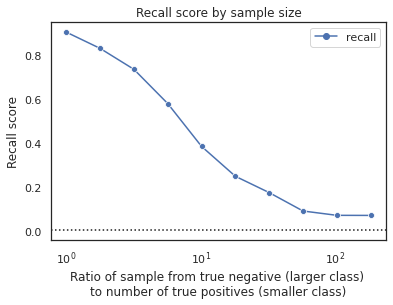

In [ ]:
sns.lineplot(data=results.set_index('true negative sample : true positive ratio')[['recall']], markers=True);
plt.xscale('log')
plt.gca().axhline(baseline, c='k', ls=':')
plt.title('Recall score by sample size');
plt.ylabel('Recall score');
plt.xlabel('Ratio of sample from true negative (larger class) \nto number of true positives (smaller class)');

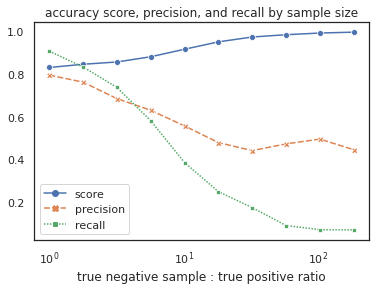

In [ ]:
sns.lineplot(data=results.set_index('true negative sample : true positive ratio')[['score','precision', 'recall']], markers=True);
plt.xscale('log')
plt.title('accuracy score, precision, and recall by sample size');

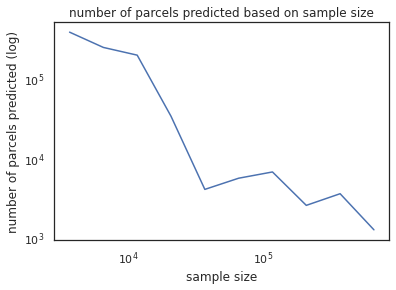

In [ ]:
sns.lineplot(data=results,
             x='sample size',
             y='num parcels predicted')
plt.yscale('log')
plt.xscale('log')
plt.title('number of parcels predicted based on sample size')
plt.ylabel('number of parcels predicted (log)');